In [1]:
# ============================================
# Finance Case Study Lab: End-to-End Pipeline
# Dataset: bank_with_missing.csv  (intentionally includes NaNs)
# Target: y (term deposit subscription: yes/no)
# ============================================



In [2]:
# 0) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, roc_curve
)


In [3]:
# 1) Read  CSV and preview , also share size of dataset

In [4]:
df = pd.read_csv("bank_with_missing.csv")  # <-- file you generated earlier
print("Shape:", df.shape)
print("\nTop 5 rows (may include NaNs):")
display(df.head())


Shape: (45211, 17)

Top 5 rows (may include NaNs):


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,NaN,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
# ==========================================================
# ==============   T A S K   1 (Cleaning)   ================
# count and display NA values for each column 


# A. 'age' (numeric): Fill missing with MEAN

# B. 'job' (categorical): Fill missing with MODE

# C. 'balance' (numeric): Drop rows where balance is NaN
#
# Explain each choice briefly in comments.


In [6]:
# A. Mean imputation (age): works well for roughly symmetric distributions
print("\n[Cleaning] A: Fill 'age' NaNs with mean")
age_nan_before = df['age'].isna().sum()
df['age'].fillna(df['age'].mean(), inplace=True)
print(f"  'age' NaNs before: {age_nan_before} -> after: {df['age'].isna().sum()}")



[Cleaning] A: Fill 'age' NaNs with mean
  'age' NaNs before: 100 -> after: 0


In [7]:

# B. Mode imputation (job): best for a single-label categorical column
print("\n[Cleaning] B: Fill 'job' NaNs with mode")
job_nan_before = df['job'].isna().sum()
df['job'].fillna(df['job'].mode()[0], inplace=True)
print(f"  'job' NaNs before: {job_nan_before} -> after: {df['job'].isna().sum()}")


[Cleaning] B: Fill 'job' NaNs with mode
  'job' NaNs before: 120 -> after: 0


In [8]:


# C. Drop rows with missing balance: assume missing implies unreliable record
print("\n[Cleaning] C: Drop rows where 'balance' is NaN")
shape_before = df.shape
df = df.dropna(subset=['balance'])
print(f"  Shape before: {shape_before} -> after: {df.shape}")
print("  Remaining NaNs:")
display(df.isnull().sum().sort_values(ascending=False))




[Cleaning] C: Drop rows where 'balance' is NaN
  Shape before: (45211, 17) -> after: (45131, 17)
  Remaining NaNs:


age          0
day          0
poutcome     0
previous     0
pdays        0
campaign     0
duration     0
month        0
contact      0
job          0
loan         0
housing      0
balance      0
default      0
education    0
marital      0
y            0
dtype: int64

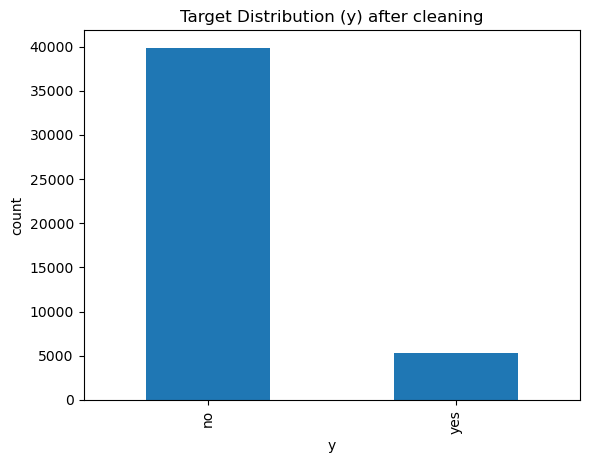

In [9]:
# Optional sanity check visuals (kept minimal)
plt.figure()
df['y'].value_counts().plot(kind='bar')
plt.title("Target Distribution (y) after cleaning")
plt.xlabel("y")
plt.ylabel("count")
plt.show()


In [10]:
# ==========================================================
# ==============   T A S K   2 (Encoding)   =================
# Encode the target 'y' into 0/1. 
# Then one-hot encode other
# categorical columns using pd.get_dummies (drop_first=True).
# ----------------------------------------------------------

In [11]:
# Encode target
print("\n[Encoding] Target 'y' -> 0/1")
le = LabelEncoder()
df['y'] = le.fit_transform(df['y'])  # yes->1, no->0 (typically)


[Encoding] Target 'y' -> 0/1


In [12]:
df['y'].value_counts()

0    39856
1     5275
Name: y, dtype: int64

In [13]:
# One-hot encode the features (excluding target)
X_raw = df.drop(columns=['y'])
y = df['y']
X = pd.get_dummies(X_raw, drop_first=True)

print("Feature matrix shape (after encoding):", X.shape)


Feature matrix shape (after encoding): (45131, 42)


In [14]:
X.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58.000000,2143.0,5,261,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,44.000000,29.0,5,151,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33.000000,2.0,5,76,1,-1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,47.000000,1506.0,5,92,1,-1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,40.937399,1.0,5,198,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [15]:
# ==========================================================
# ==============   T A S K   3 (Split)   ====================
# Do a stratified train/test split (80/20).
# -----------------------------------------------------------
# ==============   S O L U T I O N   3   ===================


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("\n[Split] Train shapes:", X_train.shape, y_train.shape)
print("[Split] Test shapes:", X_test.shape, y_test.shape)




[Split] Train shapes: (36104, 42) (36104,)
[Split] Test shapes: (9027, 42) (9027,)


In [17]:
# ==========================================================
# ==============   T A S K   4 (Scale)   ====================
# Scale numeric features using StandardScaler.
# IMPORTANT: Fit scaler on TRAIN only; transform TRAIN & TEST.
# -----------------------------------------------------------


In [18]:
# ==============   S O L U T I O N   4   ===================
scaler = StandardScaler(with_mean=False)  # with_mean=False to be safe with sparse dummies
# If X is dense (likely), you can also use with_mean=True. We'll convert to numpy arrays.

X_train_np = X_train.values.astype(float)
X_test_np  = X_test.values.astype(float)

scaler.fit(X_train_np)
X_train_sc = scaler.transform(X_train_np)
X_test_sc  = scaler.transform(X_test_np)

print("\n[Scaling] Completed (fit on train, applied to test)")



[Scaling] Completed (fit on train, applied to test)


In [19]:
X_train_sc[0:5]

array([[ 2.54770848,  0.7311342 ,  1.91907551,  0.5099265 ,  0.32412598,
         3.22784369,  0.41681223,  2.41357347,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  2.04398952,  0.        ,
         2.00100126,  0.        ,  0.        ,  0.        ,  2.01252676,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  5.13070116,
         0.        ,  0.        ],
       [ 3.96310208,  0.82947192,  3.11849771,  0.71781961,  0.64825195,
        -0.00999332,  0.        ,  0.        ,  0.        ,  0.        ,
         2.46764259,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  2.04398952,  0.        ,
         0.        ,  2.199974  ,  0.        ,  0.        ,  0.        ,
         0.     

In [20]:
# ==========================================================
# ==============   T A S K   5 (Models)   ===================
# Train:
#   - Logistic Regression (max_iter=1000)
#   - Decision Tree (use a reasonable depth, e.g., max_depth=5)
# Evaluate both on TEST set using:
#   - Accuracy
#   - Classification Report
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 03-10-2025
#   - Confusion Matrix (plot)
#   - ROC Curve + AUC


In [21]:
# ==============   S O L U T I O N   5   ===================

# Models
log_clf = LogisticRegression(max_iter=1000, random_state=42)


# Fit
log_clf.fit(X_train_sc, y_train)


# Predict
y_pred_log = log_clf.predict(X_test_sc)


# Probabilities (for ROC/AUC)
y_prob_log = log_clf.predict_proba(X_test_sc)[:, 1]




In [22]:
# Metrics
print("\n=== Holdout Evaluation (20% Test) ===")
print("\nLogistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, digits=4))



=== Holdout Evaluation (20% Test) ===

Logistic Regression
Accuracy: 0.9008529965658579
              precision    recall  f1-score   support

           0     0.9213    0.9706    0.9453      7972
           1     0.6274    0.3735    0.4682      1055

    accuracy                         0.9009      9027
   macro avg     0.7743    0.6721    0.7068      9027
weighted avg     0.8870    0.9009    0.8896      9027



In [23]:
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)

tree_clf.fit(X_train_sc, y_train)
y_pred_tree = tree_clf.predict(X_test_sc)
y_prob_tree = tree_clf.predict_proba(X_test_sc)[:, 1]

In [24]:
print("Decision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree, digits=4))


Decision Tree
Accuracy: 0.8995236512684169
              precision    recall  f1-score   support

           0     0.9202    0.9704    0.9446      7972
           1     0.6194    0.3640    0.4585      1055

    accuracy                         0.8995      9027
   macro avg     0.7698    0.6672    0.7016      9027
weighted avg     0.8850    0.8995    0.8878      9027



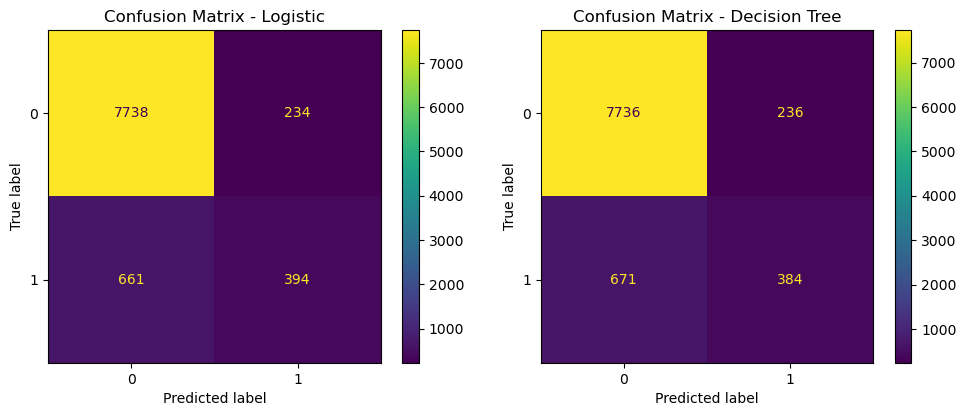

In [25]:
# Confusion Matrices
fig, axs = plt.subplots(1, 2, figsize=(10,4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, ax=axs[0])

axs[0].set_title("Confusion Matrix - Logistic")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree, ax=axs[1])

axs[1].set_title("Confusion Matrix - Decision Tree")
plt.tight_layout()
plt.show()


In [26]:
# ROC Curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
auc_log = roc_auc_score(y_test, y_prob_log)
auc_tree = roc_auc_score(y_test, y_prob_tree)



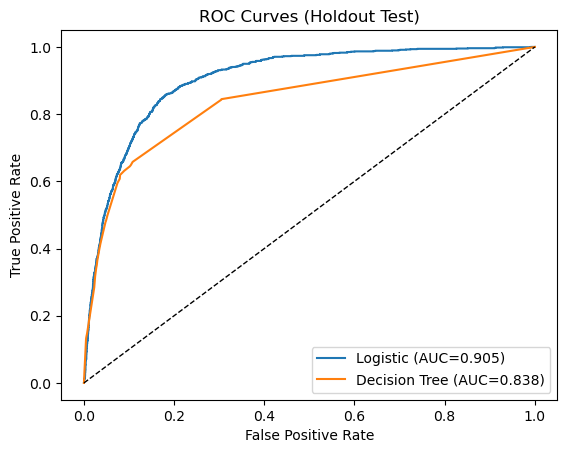

In [27]:
plt.figure()
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC={auc_log:.3f})")
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC={auc_tree:.3f})")
plt.plot([0,1], [0,1], 'k--', linewidth=1)   # ✅ fixed line — properly closed brackets
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Holdout Test)")
plt.legend()
plt.show()
